In [17]:
import numpy as np
import pandas as pd
import xgboost
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import warnings
from copy import deepcopy
import matplotlib.pyplot as plt
from xgboost import plot_importance
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook")
sns.set_palette("cubehelix", 8)#"deep")
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from problem_creator import gen_regression_symbolic, gen_classification_symbolic
from scipy.stats import weightedtau
from mlxtend.evaluate import feature_importance_permutation
from skimage.io import imread, imshow

## Utils

In [83]:
def train_and_evaluate_model(model, x, y, score_metric=mse):
    split = round(x.shape[0]*0.8)
    x_train = x[:split,:] #train_test_split(x, y, test_size=0.2)#, random_state=7)
    y_train = y[:split]
    x_test = x[split:,:]
    y_test = y[split:]
    #feature_names = [i for i in range(x.shape[1])]
    #x_train_df = pd.DataFrame(x_train,columns=feature_names)
    #x_test_df = pd.DataFrame(x_test,columns=feature_names)

    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    score = score_metric(preds, y_test)
    return model, score

def calculate_tree_shap_coeffs(model, x):
    x = x.astype(float)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x)
    shap_coeffs = np.absolute(shap_values).mean(axis=0)
    return shap_coeffs, explainer, shap_values

def create_test_data_uniform(data_points=1000, num_features=5, coeffs=None, data_params=None):
    if not data_params:
        data_params=(-1,1)
    if len(coeffs) == 0:
        coeffs = [(i+1)*2 for i in range(num_features)]
    x = []
    for i in range(len(coeffs)):
        x.append(np.random.uniform(data_params[0],data_params[1],data_points))
    x = np.array(x).T
    fi = deepcopy(x)
    for i in range(len(coeffs)):
        fi[:,i] = fi[:,i]*coeffs[i]
    y = fi.sum(1)
    return x, y, fi



def create_test_data_correlated(data_points=1000, num_features=5, coeffs=None, data_params=None):
    x1 = np.random.uniform(data_params[0],data_params[1],data_points)
    x2 = np.random.uniform(data_params[0],data_params[1],data_points)
    x3 = np.random.uniform(data_params[0],data_params[1],data_points)
    
    noise = np.random.normal(size=x1.shape)
    x4 = np.array(x1)+num_features*noise
    
    
    noise2 = np.random.normal(size=x1.shape)
    x1 = np.array(x1)+num_features*noise2
    x2 = np.array(x2)+num_features*noise2
    x3 = np.array(x3)+num_features*noise2
    
    X_coeff = np.array([x1*1,x2*2,x3*3,x4*4]).T
    X = np.array([x1,x2,x3,x4]).T
    
    y = np.sum(X_coeff,axis=1)
    return X,y,X_coeff

def create_test_data_polynome( data_points=1000, num_features=5, coeffs=None, data_params=None):

    x1 = np.random.uniform(data_params[0],data_params[1],data_points)
    x2 = np.random.uniform(data_params[0],data_params[1],data_points)
    x3 = np.random.uniform(data_params[0],data_params[1],data_points)
    x4 = np.random.uniform(data_params[0],data_params[1],data_points)
    
    X = np.array([x1,x2,x3,x4]).T
    X_coeff = np.array([x1,x2*2,x3*3,x4*4]).T
    poly = PolynomialFeatures(num_features, include_bias=False, interaction_only=True)
    X_y = poly.fit_transform(X_coeff)
    y = np.sum(X_y,axis=1)
    return X, y, X_y

def create_test_data_normal(data_points=1000, num_features=5, coeffs=[], data_params=None):
    if not data_params:
        data_params=(0,1)
    if len(coeffs) == 0:
        coeffs = [(i+1)*2 for i in range(num_features)]
    x = []
    for i in range(len(coeffs)):
        x.append(np.random.normal(data_params[0],data_params[1],data_points))
    x = np.array(x).T
    fi = deepcopy(x)
    for i in range(len(coeffs)):
        fi[:,i] = fi[:,i]*coeffs[i]
    y = fi.sum(1)
    return x, y, fi

def extract_xgb_fis(fitted_model, methods, num_features):
    fi_dict = {}
    for method in methods:
        method_dict = fitted_model.get_booster().get_score(importance_type=method)
        fi_dict[method] = method_dict

    fi_df = pd.DataFrame(fi_dict)
#     if len(fi_df) < num_features:
#         index = [int(i) for i in fi_df.index]
#         for missing_feature in np.setdiff1d([i for i in range(num_features)], index):
#             temp = pd.DataFrame({missing_feature:[0 for i in range(len(methods))]}).T
#             temp.columns = methods
#             fi_df = temp.append(fi_df)
    return fi_df

def add_noise(x,degree=0.1):
    noise = np.random.normal(size=x.shape)
    x_with_noise = np.array(x)+degree*noise
    return x_with_noise

def compare_fi_methods(num_data=1000, 
                       create_data=create_test_data_uniform, 
                       num_features=5, 
                       coeffs=[], 
                       scaling=True, 
                       methods=['gain','weight', 'cover', 'total_cover','total_gain'],
                       model_metric=mse,
                       data_params=None,
                       noise=0):
    # create coefficients if none are given
    if len(coeffs) == 0:
        coeffs = [(i+1)*2 for i in range(num_features)]
    # create data
    x, y, fi = create_data(data_points=num_data, num_features=num_features, coeffs=coeffs, data_params=data_params)
    
    # add noise
    if noise > 0:
        x = add_noise(x,noise)
    # scale
    if scaling:
        scaler = StandardScaler()
        x = scaler.fit_transform(x)

    
    # build and train and evaluate a model
    model = xgboost.XGBRegressor(gbtree='gbtree', objective='reg:squarederror')
    fitted_model, score = train_and_evaluate_model(model, x, y, model_metric)
    
    # extract fi-values for all given methods
    fi_df = extract_xgb_fis(fitted_model, methods, num_features)
    
    
    # add zero fi for unused features
    features = ['f{}'.format(i) for i in range(len(coeffs))]
    if len(features) > len(fi_df.index):
        for missing_feature in np.setdiff1d(features, fi_df.index):
            temp = pd.DataFrame({missing_feature:[0 for i in range(len(methods))]}).T
            temp.columns = methods
            fi_df = temp.append(fi_df)
    
    # compute permutation fi
    permutation_fi , _ = feature_importance_permutation(x, y, fitted_model.predict, metric='r2', num_rounds=3)
    
    # copute shapley values and global shap fi 
    shap_coeffs, explainer, shap_values = calculate_tree_shap_coeffs(fitted_model, x)
    shaps = np.absolute(shap_values).mean(axis=0)
    
    
    # set index
    new_index = [int(i[1:]) for i in fi_df.index]
    fi_df = fi_df.set_index(pd.Series(new_index))
    fi_df = fi_df.sort_index()

    # add shap fi values to 
    fi_df['SHAP'] = np.array(shaps)
    fi_df['permutation fi'] = np.array(permutation_fi)/np.sum(permutation_fi)
    fi_df['True'] = np.array(coeffs)
    return fi_df, score

def single_experiment_row(num_features = 5,
                          num_datapoints = 10000,
                          data_params = (-1,1),
                          create_data = create_test_data_uniform,
                          model_metric = mae,
                          scaling=True,
                          noise=0.1,
                          num_exps = 10,
                          coeffs = []):
    
    experiment_results_fis = []
    experiment_results_diffs = []
    experiment_scores = []
    experiment_swaps = []
    for exp in range(num_exps):
        fi_df, score = compare_fi_methods(num_data=num_datapoints,
                                          num_features=num_features,
                                          create_data=create_data,
                                          model_metric=model_metric,
                                          scaling=scaling,
                                          noise=noise,
                                          data_params=data_params,
                                          coeffs=coeffs)

        rel_fi_df = fi_df.div(fi_df.sum())
        rel_diff_df = rel_fi_df.sub(rel_fi_df['True'],axis='index').abs() / len(fi_df)
        rel_diff_df = rel_diff_df.loc[:, rel_diff_df.columns != 'True']

        experiment_results_fis.append(rel_fi_df)#.sort_values(by='True').reset_index().drop('index',axis=1))
        experiment_results_diffs.append(rel_diff_df.sum())
        experiment_scores.append(score)
        
        
        tmp = rel_fi_df[rel_fi_df['True'] > 0.001]
        
        true = tmp['True']
        true_rank = [i for i,_ in enumerate(true)]
        def apply_weighted_kendall_tau(a):
            tau, _ = weightedtau(true, a, rank=true_rank)
            return tau
        swaps = tmp.loc[:, tmp.columns != 'True'].apply(apply_weighted_kendall_tau, axis='rows')
        experiment_swaps.append(swaps)

    experiment_swaps = pd.concat(experiment_swaps,axis=0)
    experiment_swaps_gb = experiment_swaps.groupby(experiment_swaps.index)
    experiment_swaps_means = experiment_swaps_gb.mean()
    experiment_swaps_stds = experiment_swaps_gb.std()
    
    experiment_results_diffs = pd.concat(experiment_results_diffs,axis=0)
    experiment_results_diffs_gb = experiment_results_diffs.groupby(experiment_results_diffs.index)
    experiment_diffs_mean_df = experiment_results_diffs_gb.mean()
    experiment_diffs_std_df = experiment_results_diffs_gb.std()
    
    experiment_results_fis = pd.concat(experiment_results_fis,axis=0)
    experiment_results_fis_gb = experiment_results_fis.groupby(experiment_results_fis.index)
    experiment_fis_mean_df = experiment_results_fis_gb.mean()
    experiment_fis_std_df = experiment_results_fis_gb.std()
    
    mean_score = np.mean(experiment_scores)
    std_score = np.std(experiment_scores)
    
    return experiment_diffs_mean_df, experiment_diffs_std_df, mean_score, std_score, experiment_fis_mean_df, experiment_fis_std_df, experiment_swaps_means, experiment_swaps_stds

def plot_comparison_results(figsize, 
                            fontsize, 
                            title_text, 
                            xlabel, 
                            compare_diffs_mean_df, 
                            compare_diffs_std_df,
                            compare_scores_mean_df,
                            compare_scores_std_df,
                            compare_mean_swaps_df,
                            compare_std_swaps_df):
    columns = ['cover', 'total_cover','gain','total_gain', 'weight', 'permutation fi', 'SHAP']
    
    f, (ax2, ax3, ax1) = plt.subplots(3, 1, sharex=True, figsize=figsize)

    compare_diffs_mean_df[columns].plot.bar(ax=ax2, yerr=compare_diffs_std_df,capsize=2,
                                   title='Comparison of FI-Estimators \n{}'.format(title_text))
    ax2.set_xlabel(xlabel,fontsize=fontsize)
    ax2.tick_params(labelsize=fontsize)
    ax2.set_ylabel('Relative FI Error',fontsize=fontsize)
    ax2.title.set_size(fontsize+3)
    ax2.legend(fontsize=fontsize,framealpha=0.5)
    

    compare_scores_mean_df.columns = ['MAE XGBoost']
    compare_scores_mean_df.plot.bar(ax=ax1, yerr=compare_scores_std_df,capsize=2,width=0.1,color='grey')
    ax1.set_xlabel(xlabel,fontsize=fontsize)
    ax1.set_ylabel('MAE XGBoost',fontsize=fontsize)
    ax1.title.set_size(fontsize+3)
    ax1.tick_params(labelsize=fontsize)
    ax1.legend(fontsize=fontsize,framealpha=0.5)
    
    compare_mean_swaps_df[columns].plot.bar(ax=ax3, yerr=compare_std_swaps_df,capsize=2)
    ax3.set_xlabel(xlabel,fontsize=fontsize)
    ax3.set_ylabel('Permutation Score',fontsize=fontsize)
    ax3.title.set_size(fontsize+3)
    ax3.tick_params(labelsize=fontsize)
    ax3.legend(fontsize=fontsize,framealpha=0.5)
    ax3.legend().set_visible(False)
    
    
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
def minSwaps(arr): 
    n = len(arr)  
    arrpos = [*enumerate(arr)] 
    arrpos.sort(key = lambda it:it[1]) 
    vis = {k:False for k in range(n)} 
    ans = 0
    for i in range(n): 

        if vis[i] or arrpos[i][0] == i: 
            continue

        cycle_size = 0
        j = i 
        while not vis[j]: 
            vis[j] = True
            j = arrpos[j][0] 
            cycle_size += 1
        if cycle_size > 0: 
            ans += (cycle_size - 1) 
    return ans/n

## Test Experiment

In [67]:
# num_features = 6
# num_datapoints = 1000
# data_params = (-1,1)
# create_data = create_test_data_uniform
# data='uniform'
# model_metric = mae
# scaling = False
# noise = 0
# num_exps = 2
# num = 5#[0,1,5,10,20]
# coeffs = [1,2,3]

num_features = 10
num_datapoints = 1000
data_params = (-1,1)
create_data = create_test_data_uniform
data='uniform'
model_metric = mae
scaling = True
noise = 0
num_exps = 10
usless_part = [0,1,5,10,20,50]
coeffs_ = [i+1 for i in range(num_features)]
num = 5
coeffs = deepcopy(coeffs_)
for i in range(num):
    coeffs.append(0)



# # for i in range(num):
# #         coeffs.append(0)
# print(coeffs)      
# diffs_mean_df, diffs_std_df, mean_score, std_score, fis_mean_df, fis_std_df, swaps_means, swaps_std = single_experiment_row(num_features = len(coeffs),
#                                                                                                                            num_datapoints = num_datapoints,
#                                                                                                                            data_params = data_params,
#                                                                                                                            create_data = create_data,
#                                                                                                                            model_metric = model_metric,
#                                                                                                                            scaling = scaling,
#                                                                                                                            noise = noise,
#                                                                                                                            num_exps = num_exps,
#                                                                                                                            coeffs=coeffs)

### Step by Step Guide

In [68]:
fi_df, score = compare_fi_methods(num_data=num_datapoints,
                                  num_features=num_features,
                                  create_data=create_data,
                                  model_metric=model_metric,
                                  scaling=scaling,
                                  noise=noise,
                                  data_params=data_params,#,
                                  coeffs=coeffs)
fi_df = fi_df[['gain', 'weight', 'cover', 'total_cover','total_gain','permutation fi','SHAP','True']]
fi_df

,gain,weight,cover,total_cover,total_gain,permutation fi,SHAP,True
0,51.703778,15,362.466667,5437.0,775.556672,0.001128,0.183122,1
1,65.609952,39,306.512821,11954.0,2558.788132,0.004122,0.417992,2
2,210.290484,48,332.791667,15974.0,10093.943252,0.015760,1.023880,3
3,293.556296,68,291.426471,19817.0,19961.828129,0.029908,1.386769,4
4,521.096715,72,342.666667,24672.0,37518.963483,0.063965,2.008525,5
5,537.808974,75,381.893333,28642.0,40335.673082,0.081506,2.359137,6
6,780.322867,86,346.151163,29769.0,67107.766552,0.120455,2.973981,7
7,919.860321,96,356.552083,34229.0,88306.590813,0.166406,3.602652,8
8,1226.292277,97,345.381443,33502.0,118950.350853,0.221134,4.013587,9
9,1540.535651,89,393.966292,35063.0,137107.672949,0.295337,4.526132,10


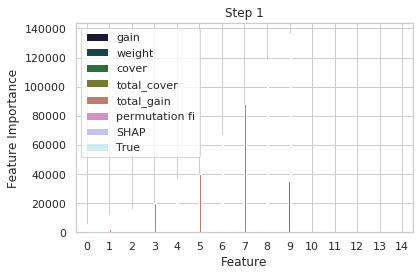

In [69]:
fi_df.plot.bar()
plt.title('Step 1')
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('plots/Step1')
plt.show()

In [70]:
fi_df = fi_df / fi_df.sum()
fi_df

,gain,weight,cover,total_cover,total_gain,permutation fi,SHAP,True
0,0.008306,0.021459,0.097670,0.022654,0.001483,0.001128,0.008128,0.018182
1,0.010540,0.055794,0.082593,0.049809,0.004892,0.004122,0.018554,0.036364
2,0.033782,0.068670,0.089674,0.066559,0.019298,0.015760,0.045448,0.054545
3,0.047158,0.097282,0.078527,0.082572,0.038164,0.029908,0.061555,0.072727
4,0.083712,0.103004,0.092335,0.102801,0.071730,0.063965,0.089154,0.090909
5,0.086397,0.107296,0.102905,0.119343,0.077115,0.081506,0.104716,0.109091
6,0.125355,0.123033,0.093273,0.124039,0.128299,0.120455,0.132008,0.127273
7,0.147771,0.137339,0.096076,0.142623,0.168827,0.166406,0.159913,0.145455
8,0.196998,0.138770,0.093066,0.139593,0.227413,0.221134,0.178153,0.163636
9,0.247480,0.127325,0.106158,0.146098,0.262127,0.295337,0.200904,0.181818


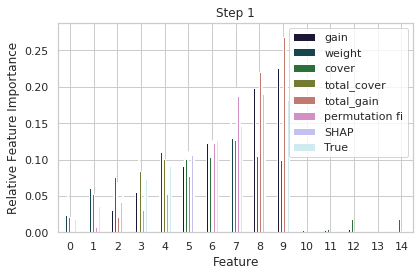

In [55]:
fi_df.plot.bar()
plt.title('Step 1')
plt.xlabel('Feature')
plt.ylabel('Relative Feature Importance')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('plots/Step2')
plt.show()

In [9]:
fi_df.loc[:, fi_df.columns != 'True']

,gain,weight,cover,total_cover,total_gain,permutation fi,SHAP
0,0.013892,0.106017,0.145202,0.090850,0.007965,0.006965,0.034752
1,0.045100,0.154728,0.139459,0.127348,0.037739,0.034279,0.084033
2,0.102280,0.167622,0.161299,0.159566,0.092720,0.090634,0.136520
3,0.190357,0.181948,0.174396,0.187268,0.187313,0.176294,0.194439
4,0.241661,0.204871,0.176401,0.213286,0.267755,0.270152,0.243317
5,0.406710,0.184814,0.203244,0.221682,0.406508,0.421675,0.306939


In [10]:
true = fi_df['True']
true_rank = [i for i,_ in enumerate(true)]
def apply_weighted_kendall_tau(a):
    tau, _ = weightedtau(true, a, rank=true_rank)
    return tau
fi_df = fi_df.loc[:, fi_df.columns != 'True'].apply(apply_weighted_kendall_tau, axis='rows')
fi_df

gain              1.000000
weight            0.940136
cover             0.755102
total_cover       1.000000
total_gain        1.000000
permutation fi    1.000000
SHAP              1.000000
dtype: float64

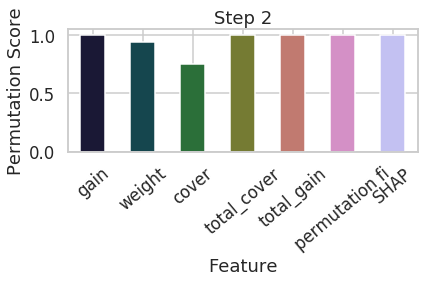

In [11]:
fi_df.plot.bar()
plt.title('Step 2')
plt.xlabel('Feature')
plt.ylabel('Permutation Score')
plt.xticks(rotation=40)
plt.tight_layout()
plt.savefig('plots/Step3')
plt.show()

In [12]:
ps_list = []
for i in range(10):
    fi_df, score = compare_fi_methods(num_data=num_datapoints,
                                  num_features=num_features,
                                  create_data=create_data,
                                  model_metric=model_metric,
                                  scaling=scaling,
                                  noise=noise,
                                  data_params=data_params)#,
#                                   coeffs=coeffs)
    fi_df = fi_df[['gain', 'weight', 'cover', 'total_cover','total_gain','permutation fi','SHAP','True']]
    
    fi_df = fi_df / fi_df.sum()
    
    true = fi_df['True']
    true_rank = [i for i,_ in enumerate(true)]
    def apply_weighted_kendall_tau(a):
        tau, _ = weightedtau(true, a, rank=true_rank)
        return tau
    fi_df = fi_df.loc[:, fi_df.columns != 'True'].apply(apply_weighted_kendall_tau, axis='rows')
    
    ps_list.append(fi_df)

ps_df = pd.concat(ps_list,axis=1)
ps_df

,0,1,2,3,4,5,6,7,8,9
gain,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
weight,0.940136,0.798639,0.844898,0.940136,0.872109,0.717007,0.872109,0.872109,0.926531,0.872109
cover,0.537415,0.627211,0.553741,-0.417687,0.466667,0.333333,0.553741,0.050340,0.491156,0.695238
total_cover,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
total_gain,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
permutation fi,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
SHAP,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


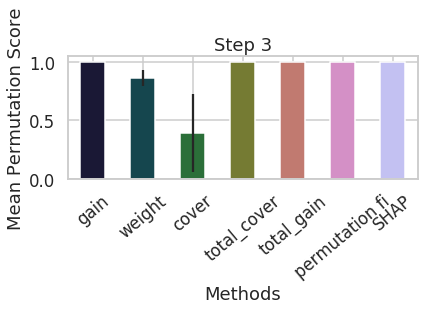

In [13]:
ps_df_mean = ps_df.mean(axis=1)
ps_df_std = ps_df.std(axis=1)  
ps_df_mean.plot.bar(yerr=ps_df_std)
plt.title('Step 3')
plt.xlabel('Methods')
plt.ylabel('Mean Permutation Score')
plt.xticks(rotation=40)
plt.tight_layout()
plt.savefig('plots/Step4')
plt.show()

In [14]:
nums = [3,6,9]
means = []
stds = []
for num_features in nums:
    sums_list = []
    for i in range(10):
        fi_df, score = compare_fi_methods(num_data=num_datapoints,
                                      num_features=num_features,
                                      create_data=create_data,
                                      model_metric=model_metric,
                                      scaling=scaling,
                                      noise=noise,
                                      data_params=data_params)#,
    #                                   coeffs=coeffs)
        fi_df = fi_df[['gain', 'weight', 'cover', 'total_cover','total_gain','permutation fi','SHAP','True']]

        fi_df = fi_df / fi_df.sum()

        true = fi_df['True']
        true_rank = [i for i,_ in enumerate(true)]
        def apply_weighted_kendall_tau(a):
            tau, _ = weightedtau(true, a, rank=true_rank)
            return tau
        fi_df = fi_df.loc[:, fi_df.columns != 'True'].apply(apply_weighted_kendall_tau, axis='rows')

        ps_list.append(fi_df)

    ps_df = pd.concat(ps_list,axis=1)
    ps_df_mean = ps_df.mean(axis=1)
    ps_df_std = ps_df.std(axis=1)  
    means.append(ps_df_mean)
    stds.append(ps_df_std)
    
    

In [15]:
means_df = pd.concat(means,axis=1)
stds_df = pd.concat(stds,axis=1)
means_df

,0,1,2
gain,1.000000,1.000000,0.991420
weight,0.891880,0.886731,0.889229
cover,0.626376,0.594183,0.578791
total_cover,1.000000,1.000000,0.996997
total_gain,1.000000,1.000000,1.000000
permutation fi,1.000000,1.000000,1.000000
SHAP,1.000000,1.000000,1.000000


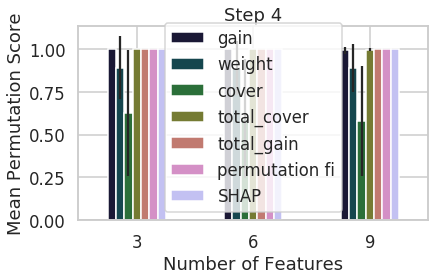

In [16]:
means_df.T.plot.bar(yerr=stds_df.T)
plt.title('Step 4')
plt.xlabel('Number of Features')
plt.ylabel('Mean Permutation Score')
plt.xticks([0,1,2],nums,rotation=0)
plt.tight_layout()
plt.savefig('plots/Step5')
plt.show()

## Comparison Experiment - Number of Features

In [6]:
num_features = [5,10,50]#,100]
num_datapoints = 1000
data_params = (-1,1)
create_data = create_test_data_uniform
data='uniform'
model_metric = mse
scaling=True
noise=0.1
num_exps = 10

compare_diffs_mean_dict = {}
compare_diffs_std_dict = {}
compare_scores_mean_dict = {}
compare_scores_std_dict = {}
compare_mean_swaps_dict = {}
compare_std_swaps_dict = {}
for num in num_features:
  
    diffs_mean_df, diffs_std_df, mean_score, std_score, _, _, swaps_means, swaps_stds = single_experiment_row(num_features = num,
                                                                                                              num_datapoints = num_datapoints,
                                                                                                              data_params = data_params,
                                                                                                              create_data = create_test_data_uniform,
                                                                                                              model_metric = model_metric,
                                                                                                              scaling = scaling,
                                                                                                              noise = noise,
                                                                                                              num_exps = num_exps)
    
    compare_scores_mean_dict[num] = mean_score
    compare_scores_std_dict[num] = std_score
    compare_diffs_mean_dict[num] = diffs_mean_df
    compare_diffs_std_dict[num] = diffs_std_df
    compare_mean_swaps_dict[num] = swaps_means
    compare_std_swaps_dict[num] = swaps_stds

    
compare_diffs_mean_df = pd.DataFrame.from_dict(compare_diffs_mean_dict,orient='index')
compare_diffs_std_df = pd.DataFrame.from_dict(compare_diffs_std_dict,orient='index')
compare_scores_mean_df = pd.DataFrame.from_dict(compare_scores_mean_dict,orient='index')
compare_scores_std_df = pd.DataFrame.from_dict(compare_scores_std_dict,orient='index')
compare_mean_swaps_df = pd.DataFrame.from_dict(compare_mean_swaps_dict,orient='index')
compare_std_swaps_df = pd.DataFrame.from_dict(compare_std_swaps_dict,orient='index')

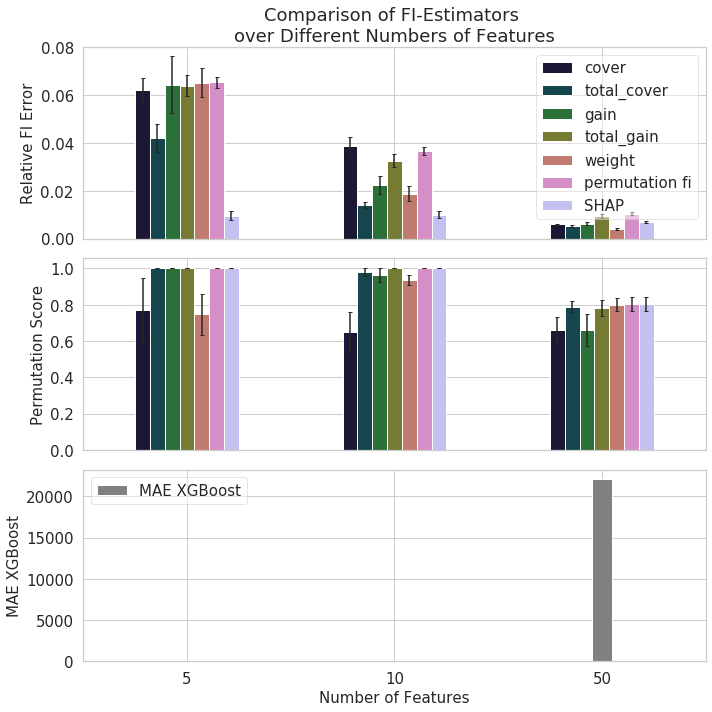

In [7]:
figsize=(10,10)
fontsize=15
title_text = 'over Different Numbers of Features'
xlabel = 'Number of Features'

plot_comparison_results(figsize, 
                        fontsize, 
                        title_text, 
                        xlabel, 
                        compare_diffs_mean_df, 
                        compare_diffs_std_df,
                        compare_scores_mean_df,
                        compare_scores_std_df,
                        compare_mean_swaps_df,
                        compare_std_swaps_df)

## Comparison Experiment - Scaling

In [61]:
# num_features = 10
# num_datapoints = 1000
# data_params = (9,10)
# create_data = create_test_data_normal
# data='normal'
# model_metric = mse
# scaling=[True, False]
# noise=0.1
# num_exps = 10


# compare_diffs_mean_dict = {}
# compare_diffs_std_dict = {}
# compare_scores_mean_dict = {}
# compare_scores_std_dict = {}
# compare_mean_swaps_dict = {}
# compare_std_swaps_dict = {}
# for num in scaling:
  
#     diffs_mean_df, diffs_std_df, mean_score, std_score, _, _, swaps_means, swaps_stds = single_experiment_row(num_features = num_features,
#                                                                                                               num_datapoints = num_datapoints,
#                                                                                                               data_params = data_params,
#                                                                                                               create_data = create_test_data_uniform,
#                                                                                                               model_metric = model_metric,
#                                                                                                               scaling = num,
#                                                                                                               noise = noise,
#                                                                                                               num_exps = num_exps)
    
#     compare_scores_mean_dict[num] = mean_score
#     compare_scores_std_dict[num] = std_score
#     compare_diffs_mean_dict[num] = diffs_mean_df
#     compare_diffs_std_dict[num] = diffs_std_df
#     compare_mean_swaps_dict[num] = swaps_means
#     compare_std_swaps_dict[num] = swaps_stds

    
# compare_diffs_mean_df = pd.DataFrame.from_dict(compare_diffs_mean_dict,orient='index')
# compare_diffs_std_df = pd.DataFrame.from_dict(compare_diffs_std_dict,orient='index')
# compare_scores_mean_df = pd.DataFrame.from_dict(compare_scores_mean_dict,orient='index')
# compare_scores_std_df = pd.DataFrame.from_dict(compare_scores_std_dict,orient='index')
# compare_mean_swaps_df = pd.DataFrame.from_dict(compare_mean_swaps_dict,orient='index')
# compare_std_swaps_df = pd.DataFrame.from_dict(compare_std_swaps_dict,orient='index')

In [62]:
# figsize=(9,10)
# fontsize=18
# title_text = 'Scaling'
# xlabel = 'Scaling'

# plot_comparison_results(figsize, 
#                         fontsize, 
#                         title_text, 
#                         xlabel, 
#                         compare_diffs_mean_df, 
#                         compare_diffs_std_df,
#                         compare_scores_mean_df,
#                         compare_scores_std_df,
#                         compare_mean_swaps_df,
#                         compare_std_swaps_df)

## Comparison Experiment - Number of Datapoints

In [8]:
num_features = 10
num_datapoints = [10,50,100,500,1000,5000,10000]
data_params = (-1,1)
create_data = create_test_data_uniform
data='uniform'
model_metric = mse
scaling=True
noise=0.1
num_exps = 20


compare_diffs_mean_dict = {}
compare_diffs_std_dict = {}
compare_scores_mean_dict = {}
compare_scores_std_dict = {}
compare_mean_swaps_dict = {}
compare_std_swaps_dict = {}
for num in num_datapoints:
  
    diffs_mean_df, diffs_std_df, mean_score, std_score, _, _, swaps_means, swaps_stds = single_experiment_row(num_features = num_features,
                                                                                                              num_datapoints = num,
                                                                                                              data_params = data_params,
                                                                                                              create_data = create_test_data_uniform,
                                                                                                              model_metric = model_metric,
                                                                                                              scaling=scaling,
                                                                                                              noise=noise,
                                                                                                              num_exps = num_exps)

    compare_scores_mean_dict[num] = mean_score
    compare_scores_std_dict[num] = std_score
    compare_diffs_mean_dict[num] = diffs_mean_df
    compare_diffs_std_dict[num] = diffs_std_df
    compare_mean_swaps_dict[num] = swaps_means
    compare_std_swaps_dict[num] = swaps_stds

compare_diffs_mean_df = pd.DataFrame.from_dict(compare_diffs_mean_dict,orient='index')
compare_diffs_std_df = pd.DataFrame.from_dict(compare_diffs_std_dict,orient='index')
compare_scores_mean_df = pd.DataFrame.from_dict(compare_scores_mean_dict,orient='index')
compare_scores_std_df = pd.DataFrame.from_dict(compare_scores_std_dict,orient='index')
compare_mean_swaps_df = pd.DataFrame.from_dict(compare_mean_swaps_dict,orient='index')
compare_std_swaps_df = pd.DataFrame.from_dict(compare_std_swaps_dict,orient='index')

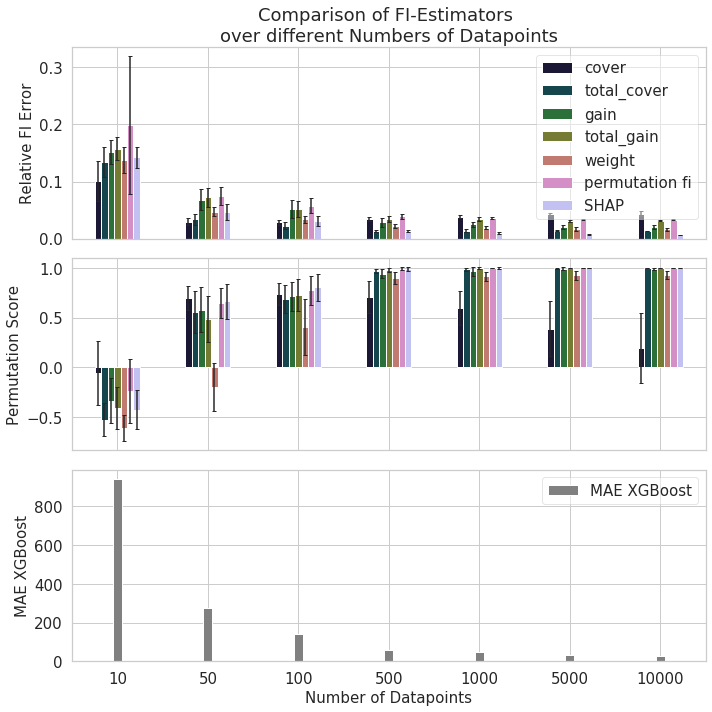

In [9]:
figsize=(10,10)
fontsize=15
title_text = 'over different Numbers of Datapoints'
xlabel = 'Number of Datapoints'

plot_comparison_results(figsize, 
                        fontsize, 
                        title_text, 
                        xlabel, 
                        compare_diffs_mean_df, 
                        compare_diffs_std_df,
                        compare_scores_mean_df,
                        compare_scores_std_df,
                        compare_mean_swaps_df,
                        compare_std_swaps_df)

## Comparison Experiment - Dregree of Noise

In [10]:
num_features = 10
num_datapoints = 1000
data_params = (-1,1)
create_data = create_test_data_uniform
data='uniform'
model_metric = mae
scaling = True
noise = [(i)/5 for i in range(6)]
noise.append(2)
noise.append(10)
print(noise)
num_exps = 10

compare_diffs_mean_dict = {}
compare_diffs_std_dict = {}
compare_scores_mean_dict = {}
compare_scores_std_dict = {}
compare_mean_swaps_dict = {}
compare_std_swaps_dict = {}
for noise_degree in noise:
    diffs_mean_df, diffs_std_df, mean_score, std_score, _, _, swaps_means, swaps_stds = single_experiment_row(num_features = num_features,
                                                                                                              num_datapoints = num_datapoints,
                                                                                                              data_params = data_params,
                                                                                                              create_data = create_test_data_uniform,
                                                                                                              model_metric = model_metric,
                                                                                                              scaling = scaling,
                                                                                                              noise = noise_degree,
                                                                                                              num_exps = num_exps)
    
    compare_scores_mean_dict[noise_degree] = mean_score
    compare_scores_std_dict[noise_degree] = std_score
    compare_diffs_mean_dict[noise_degree] = diffs_mean_df
    compare_diffs_std_dict[noise_degree] = diffs_std_df
    compare_mean_swaps_dict[noise_degree] = swaps_means
    compare_std_swaps_dict[noise_degree] = swaps_stds
  
compare_diffs_mean_df = pd.DataFrame.from_dict(compare_diffs_mean_dict,orient='index')
compare_diffs_std_df = pd.DataFrame.from_dict(compare_diffs_std_dict,orient='index')
compare_scores_mean_df = pd.DataFrame.from_dict(compare_scores_mean_dict,orient='index')
compare_scores_std_df = pd.DataFrame.from_dict(compare_scores_std_dict,orient='index')
compare_mean_swaps_df = pd.DataFrame.from_dict(compare_mean_swaps_dict,orient='index')
compare_std_swaps_df = pd.DataFrame.from_dict(compare_std_swaps_dict,orient='index')

[0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 2, 10]


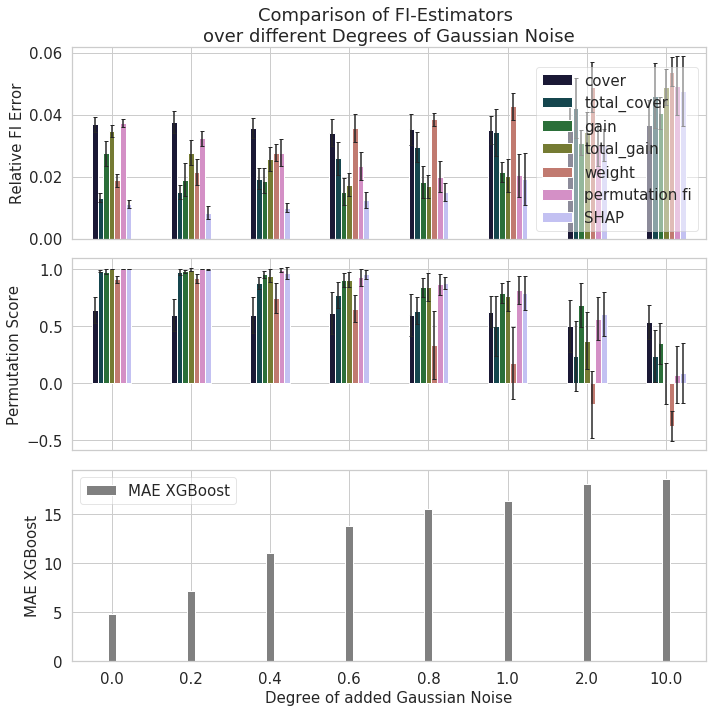

In [11]:
figsize=(10,10)
fontsize=15
title_text = 'over different Degrees of Gaussian Noise'
xlabel = 'Degree of added Gaussian Noise'

plot_comparison_results(figsize, 
                        fontsize, 
                        title_text, 
                        xlabel, 
                        compare_diffs_mean_df, 
                        compare_diffs_std_df,
                        compare_scores_mean_df,
                        compare_scores_std_df,
                        compare_mean_swaps_df,
                        compare_std_swaps_df)

## Comparison Experiment - Distances of FIs

In [90]:
num_features = 10
num_datapoints = 1000
data_params = (-1,1)
create_data = create_test_data_uniform
data='uniform'
model_metric = mae
scaling = False
noise = 0
num_exps = 10
coeffs_list = [[1 for i in range(num_features)],
              [(i+1)*0.1 for i in range(num_features)],
              [(i+1) for i in range(num_features)],
              [(i+1)**2 for i in range(num_features)]]


#coeffs_list = [np.array(sub_list)/np.sum(sub_list) for sub_list in coeffs_list]
fi_diffs = ['0','0.1','1','exp_2']

compare_diffs_mean_dict = {}
compare_diffs_std_dict = {}
compare_scores_mean_dict = {}
compare_scores_std_dict = {}
compare_mean_swaps_dict = {}
compare_std_swaps_dict = {}
for i, coeffs in enumerate(coeffs_list):
    print(coeffs)
    diffs_mean_df, diffs_std_df, mean_score, std_score, _, _, swaps_means, swaps_stds = single_experiment_row(num_features = num_features,
                                                                                                              num_datapoints = num_datapoints,
                                                                                                              data_params = data_params,
                                                                                                              create_data = create_test_data_uniform,
                                                                                                              model_metric = model_metric,
                                                                                                              scaling = scaling,
                                                                                                              noise = noise,
                                                                                                              num_exps = num_exps,
                                                                                                              coeffs = coeffs)
    
    compare_scores_mean_dict[fi_diffs[i]] = mean_score
    compare_scores_std_dict[fi_diffs[i]] = std_score
    compare_diffs_mean_dict[fi_diffs[i]] = diffs_mean_df
    compare_diffs_std_dict[fi_diffs[i]] = diffs_std_df
    compare_mean_swaps_dict[fi_diffs[i]] = swaps_means
    compare_std_swaps_dict[fi_diffs[i]] = swaps_stds
   
compare_diffs_mean_df = pd.DataFrame.from_dict(compare_diffs_mean_dict,orient='index')
compare_diffs_std_df = pd.DataFrame.from_dict(compare_diffs_std_dict,orient='index')
compare_scores_mean_df = pd.DataFrame.from_dict(compare_scores_mean_dict,orient='index')
compare_scores_std_df = pd.DataFrame.from_dict(compare_scores_std_dict,orient='index')
compare_mean_swaps_df = pd.DataFrame.from_dict(compare_mean_swaps_dict,orient='index')
compare_std_swaps_df = pd.DataFrame.from_dict(compare_std_swaps_dict,orient='index')

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[1, 4, 9, 16, 25, 36, 49, 64, 81, 100]


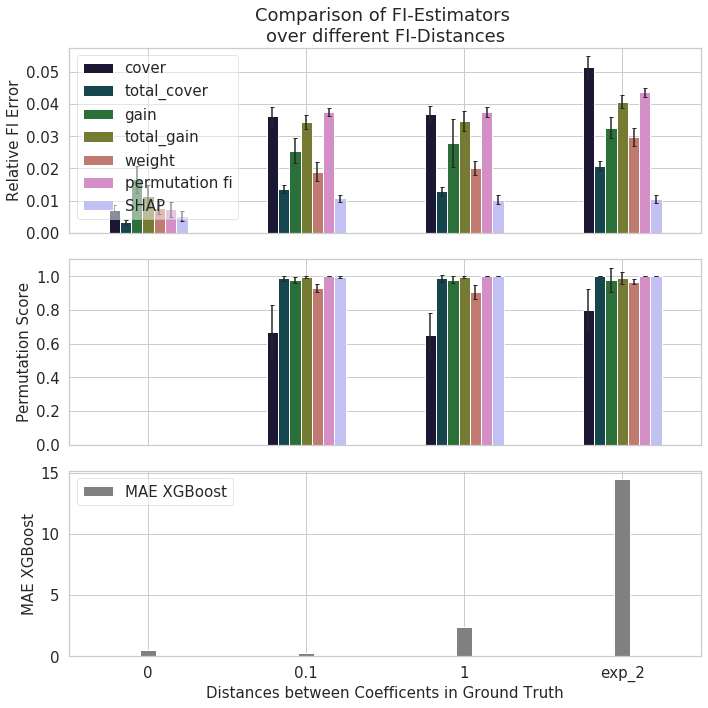

In [92]:
figsize=(10,10)
fontsize=15
title_text = 'over different FI-Distances'
xlabel = 'Distances between Coefficents in Ground Truth'

plot_comparison_results(figsize, 
                        fontsize, 
                        title_text, 
                        xlabel, 
                        compare_diffs_mean_df.loc[fi_diffs], 
                        compare_diffs_std_df.loc[fi_diffs],
                        compare_scores_mean_df.loc[fi_diffs],
                        compare_scores_std_df.loc[fi_diffs],
                        compare_mean_swaps_df.loc[fi_diffs],
                        compare_std_swaps_df.loc[fi_diffs])

## Comparison Experiment - Number of redundant Features

In [28]:
num_features = 10
num_datapoints = 1000
data_params = (-1,1)
create_data = create_test_data_uniform
data='uniform'
model_metric = mae
scaling = True
noise = 0
num_exps = 10
usless_part = [0,1,5,10,20,50]
coeffs_ = [i+1 for i in range(num_features)]


compare_diffs_mean_dict = {}
compare_diffs_std_dict = {}
compare_scores_mean_dict = {}
compare_scores_std_dict = {}
compare_mean_swaps_dict = {}
compare_std_swaps_dict = {}
for num in usless_part:
    coeffs = deepcopy(coeffs_)
    for i in range(num):
        coeffs.append(0)
    #print(len(coeffs))
    diffs_mean_df, diffs_std_df, mean_score, std_score, _, _, swaps_means, swaps_stds = single_experiment_row(num_features = len(coeffs),
                                                                                                              num_datapoints = num_datapoints,
                                                                                                              data_params = data_params,
                                                                                                              create_data = create_test_data_uniform,
                                                                                                              model_metric = model_metric,
                                                                                                              scaling = scaling,
                                                                                                              noise = noise,
                                                                                                              num_exps = num_exps,
                                                                                                              coeffs = coeffs)
    
    compare_scores_mean_dict[round(num/len(coeffs),2)] = mean_score
    compare_scores_std_dict[round(num/len(coeffs),2)] = std_score
    compare_diffs_mean_dict[round(num/len(coeffs),2)] = diffs_mean_df
    compare_diffs_std_dict[round(num/len(coeffs),2)] = diffs_std_df
    compare_mean_swaps_dict[round(num/len(coeffs),2)] = swaps_means
    compare_std_swaps_dict[round(num/len(coeffs),2)] = swaps_stds
  
compare_diffs_mean_df = pd.DataFrame.from_dict(compare_diffs_mean_dict,orient='index')
compare_diffs_std_df = pd.DataFrame.from_dict(compare_diffs_std_dict,orient='index')
compare_scores_mean_df = pd.DataFrame.from_dict(compare_scores_mean_dict,orient='index')
compare_scores_std_df = pd.DataFrame.from_dict(compare_scores_std_dict,orient='index')
compare_mean_swaps_df = pd.DataFrame.from_dict(compare_mean_swaps_dict,orient='index')
compare_std_swaps_df = pd.DataFrame.from_dict(compare_std_swaps_dict,orient='index')

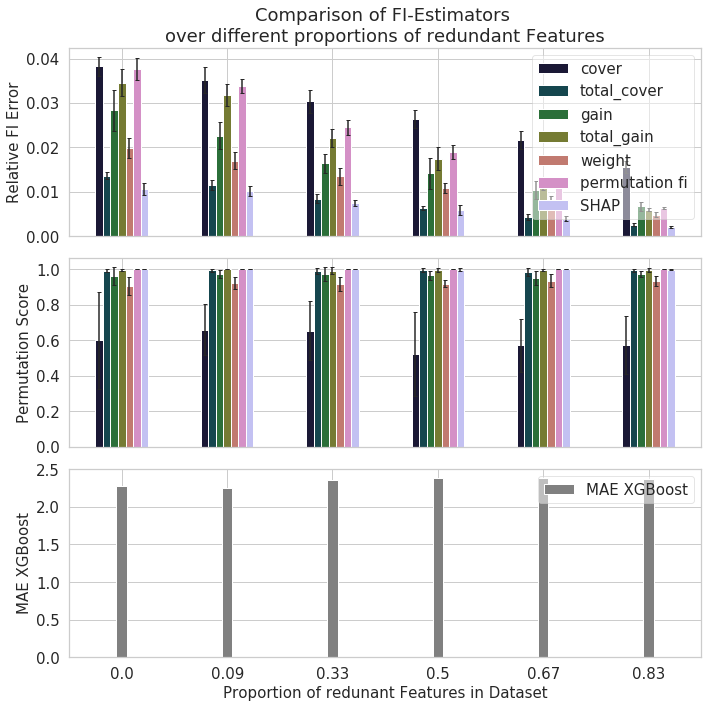

In [29]:
figsize=(10,10)
fontsize=15
title_text = 'over different proportions of redundant Features'
xlabel = 'Proportion of redunant Features in Dataset'

plot_comparison_results(figsize, 
                        fontsize, 
                        title_text, 
                        xlabel, 
                        compare_diffs_mean_df, 
                        compare_diffs_std_df,
                        compare_scores_mean_df,
                        compare_scores_std_df,
                        compare_mean_swaps_df,
                        compare_std_swaps_df)

## Comparison over different ground Truth Complexities

In [84]:
#num_features = [1,2,4,6,8]#,50,100]
num_features = [1,2,3,4]#,5]
num_datapoints = 1000
data_params = (-1,1)
create_data = create_test_data_polynome
data='uniform'
model_metric = mse
scaling=True
noise=0.1
num_exps = 10
coeffs = [1,2,3,4]#,5]

compare_diffs_mean_dict = {}
compare_diffs_std_dict = {}
compare_scores_mean_dict = {}
compare_scores_std_dict = {}
compare_mean_swaps_dict = {}
compare_std_swaps_dict = {}
for num in num_features:
  
    diffs_mean_df, diffs_std_df, mean_score, std_score, _, _, swaps_means, swaps_stds = single_experiment_row(num_features = num,
                                                                                                              num_datapoints = num_datapoints,
                                                                                                              data_params = data_params,
                                                                                                              create_data = create_data,
                                                                                                              model_metric = model_metric,
                                                                                                              scaling = scaling,
                                                                                                              noise = noise,
                                                                                                              num_exps = num_exps,
                                                                                                              coeffs = coeffs)
    
    compare_scores_mean_dict[num] = mean_score
    compare_scores_std_dict[num] = std_score
    compare_diffs_mean_dict[num] = diffs_mean_df
    compare_diffs_std_dict[num] = diffs_std_df
    compare_mean_swaps_dict[num] = swaps_means
    compare_std_swaps_dict[num] = swaps_stds

    
compare_diffs_mean_df = pd.DataFrame.from_dict(compare_diffs_mean_dict,orient='index')
compare_diffs_std_df = pd.DataFrame.from_dict(compare_diffs_std_dict,orient='index')
compare_scores_mean_df = pd.DataFrame.from_dict(compare_scores_mean_dict,orient='index')
compare_scores_std_df = pd.DataFrame.from_dict(compare_scores_std_dict,orient='index')
compare_mean_swaps_df = pd.DataFrame.from_dict(compare_mean_swaps_dict,orient='index')
compare_std_swaps_df = pd.DataFrame.from_dict(compare_std_swaps_dict,orient='index')

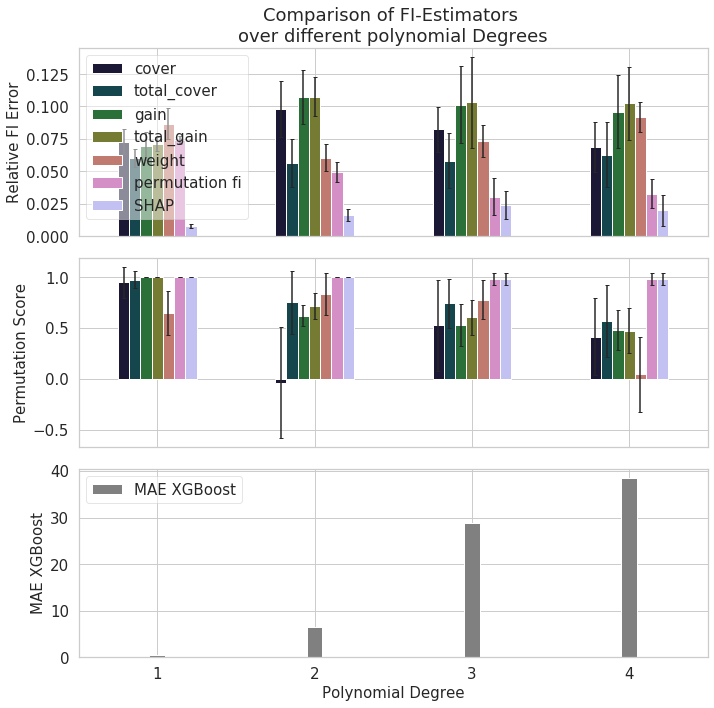

In [85]:
figsize=(10,10)
fontsize=15
title_text = 'over different polynomial Degrees'
xlabel = 'Polynomial Degree'

plot_comparison_results(figsize, 
                        fontsize, 
                        title_text, 
                        xlabel, 
                        compare_diffs_mean_df, 
                        compare_diffs_std_df,
                        compare_scores_mean_df,
                        compare_scores_std_df,
                        compare_mean_swaps_df,
                        compare_std_swaps_df)

## Feature Correlations

In [66]:
# num_features = [0.2,0.4,0.6,0.8,1]
# num_datapoints = 5000
# data_params = (-1,1)
# create_data = create_test_data_correlated
# data='uniform'
# model_metric = mse
# scaling=True
# noise=0.1
# num_exps = 10
# coeffs = [5,2,3,0]

# compare_diffs_mean_dict = {}
# compare_diffs_std_dict = {}
# compare_scores_mean_dict = {}
# compare_scores_std_dict = {}
# compare_mean_swaps_dict = {}
# compare_std_swaps_dict = {}
# for num in num_features:
  
#     diffs_mean_df, diffs_std_df, mean_score, std_score, _, _, swaps_means, swaps_stds = single_experiment_row(num_features = num,
#                                                                                                               num_datapoints = num_datapoints,
#                                                                                                               data_params = data_params,
#                                                                                                               create_data = create_data,
#                                                                                                               model_metric = model_metric,
#                                                                                                               scaling = scaling,
#                                                                                                               noise = noise,
#                                                                                                               num_exps = num_exps,
#                                                                                                               coeffs = coeffs)
    
#     compare_scores_mean_dict[num] = mean_score
#     compare_scores_std_dict[num] = std_score
#     compare_diffs_mean_dict[num] = diffs_mean_df
#     compare_diffs_std_dict[num] = diffs_std_df
#     compare_mean_swaps_dict[num] = swaps_means
#     compare_std_swaps_dict[num] = swaps_stds

    
# compare_diffs_mean_df = pd.DataFrame.from_dict(compare_diffs_mean_dict,orient='index')
# compare_diffs_std_df = pd.DataFrame.from_dict(compare_diffs_std_dict,orient='index')
# compare_scores_mean_df = pd.DataFrame.from_dict(compare_scores_mean_dict,orient='index')
# compare_scores_std_df = pd.DataFrame.from_dict(compare_scores_std_dict,orient='index')
# compare_mean_swaps_df = pd.DataFrame.from_dict(compare_mean_swaps_dict,orient='index')
# compare_std_swaps_df = pd.DataFrame.from_dict(compare_std_swaps_dict,orient='index')

In [67]:
# figsize=(10,10)
# fontsize=15
# title_text = 'over different degrees of feature correlations'
# xlabel = 'Polynome degree'

# plot_comparison_results(figsize, 
#                         fontsize, 
#                         title_text, 
#                         xlabel, 
#                         compare_diffs_mean_df, 
#                         compare_diffs_std_df,
#                         compare_scores_mean_df,
#                         compare_scores_std_df,
#                         compare_mean_swaps_df,
#                         compare_std_swaps_df)